In [1]:
import os
import sys
sys.path.insert(0, '..') # incluir modulos de la parent folder
import metnum
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import normalize

# Intención
En esta notebook estudiamos -brevemente- el comportamiento de los parametros óptimos de cada técnica (KNN, KNN+PCA) a medida que varía el tamaño del conjunto de entrenamiento. Precísamente, prestamos atención a las siguientes preguntas:
* ¿Varían los intervalos óptimos de los parámetros? ¿Podemos observar alguna tendencia? ¿Algún corrimiento?
* A raíz del análisis de un experimento anterior, contamos con los parámetros de cada técnica que maximizan el accuracy. Ahora bien, estos sólo fueron corroborados con un set de entrenamiento de un tamaño determinado. Entonces, si variamos la dimensión del trainset, ¿continuarán maximizando las metricas? En caso de que no, ¿seguirán siendo efectivos? ¿se alejarán mucho de los valores óptimos? 

## El experimento
Se llevaron a cabo una serie de corridas variando las dimensiones previamente comentadas.
* Se experimentó con trainsets de tamaños entre 6000 y 33600 elementos, con intervalos de 6000 elementos. 
* En el caso del método KNN, se tomaron valores de k en el intervalo [1 ; 15], con saltos de 2 unidades.
* Por otro lado, cuando se experimentó con KNN y PCA, se contemplaron valores de k en el intervalo [1 ; 11] con saltos de 2 unidades; y valores de alfa en entre 25 y 105, creciendo de a 10 unidades.

En todos los casos se tomó registro de las siguientes métricas: accuracy, kappa de cohen, f1, precision y recall. Además, para que la evaluacion resulte más robusta se realizó validación cruzada con 10 folds.


Para replicar el experimento sobre ambas técnicas:

> ./parallel_both

Los resultados se almacenan en los directorios `knn_results/` y `knn_pca_results/` respectivamente.

# Caso KNN

Para replicar el experimento únicamente sobre esta técnica:

> ./parallelknn

Los resultados se almacenan en el directorio `knn_results/`.


## Recuperar resultados

Primero, levantamos los resultados del experimento

In [17]:
data_files = os.listdir('knn_results')

def load_files(filenames):
    for filename in filenames:
        yield pd.read_csv(f"knn_results/{filename}")

data = pd.concat(load_files(data_files), ignore_index=True)

data.describe()

,accuracy,cohen_kappa,f1,kfold,knn,precision,predict_time,recall,train_size
count,480.000000,480.000000,480.000000,480.0,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.952424,0.947078,0.952381,10.0,8.000000,0.953609,107.238986,0.952424,20600.000000
std,0.012118,0.013499,0.012128,0.0,4.587357,0.011239,79.997431,0.012118,9695.144384
min,0.905000,0.894338,0.903445,10.0,1.000000,0.907143,9.381115,0.905000,6000.000000
25%,0.946667,0.940649,0.946591,10.0,4.500000,0.948413,31.026423,0.946667,12000.000000
50%,0.956111,0.951160,0.955977,10.0,8.000000,0.956873,92.627532,0.956111,21000.000000
75%,0.960833,0.956436,0.960800,10.0,11.500000,0.961398,184.493089,0.960833,30000.000000
max,0.970833,0.967579,0.970814,10.0,15.000000,0.970956,237.154207,0.970833,33600.000000


Luego, los agrupamos por el tamaño del set de entrenamiento y el parámetro de knn.

In [41]:
# podemos usar .mean() para resolver las métricas obtenidas de los distintos kfold

grouped = data.groupby(['train_size', 'knn']).mean()
grouped = grouped.drop(['kfold', 'predict_time'], axis=1)

grouped.head(20)

accuracy  cohen_kappa        f1  precision    recall
train_size knn                                                      
6000       1    0.937667     0.930609  0.937584   0.939075  0.937667
           3    0.937667     0.930610  0.937694   0.939523  0.937667
           5    0.938333     0.931350  0.938293   0.940224  0.938333
           7    0.935667     0.928381  0.935652   0.938136  0.935667
           9    0.931833     0.924114  0.931824   0.934691  0.931833
           11   0.931500     0.923742  0.931509   0.934954  0.931500
           13   0.928500     0.920403  0.928520   0.932213  0.928500
           15   0.924000     0.915391  0.923866   0.927824  0.924000
12000      1    0.950833     0.945304  0.950726   0.951558  0.950833
           3    0.952000     0.946601  0.951963   0.953092  0.952000
           5    0.951583     0.946140  0.951543   0.952859  0.951583
           7    0.947333     0.941411  0.947290   0.948891  0.947333
           9    0.945500     0.939369  0.945472   0.947201  0.945500
           11   0.943500     0.937144  0.943516   0.945521  0.943500
           13   0.940417     0.933711  0.940400   0.942647  0.940417
           15   0.938333     0.931392  0.938339   0.940696  0.938333
18000      1    0.958222     0.953535  0.958142   0.958600  0.958222
           3    0.960333     0.955882  0.960278   0.960878  0.960333
           5    0.958389     0.953719  0.958331   0.959074  0.958389
           7    0.957500     0.952731  0.957432   0.958260  0.957500

## Análisis

Graficamos las métricas en función del parámtero k, variando el tamaño del train set.

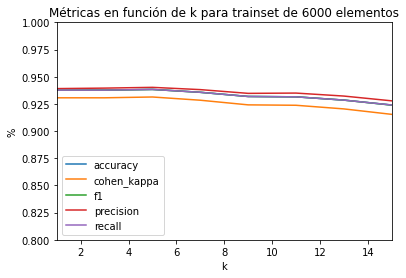

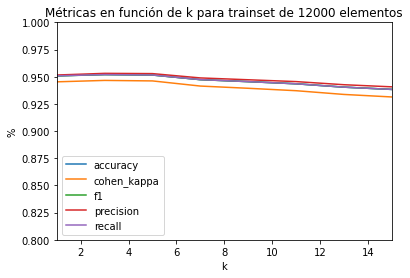

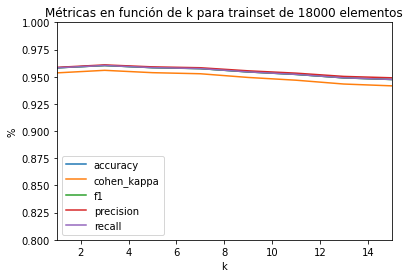

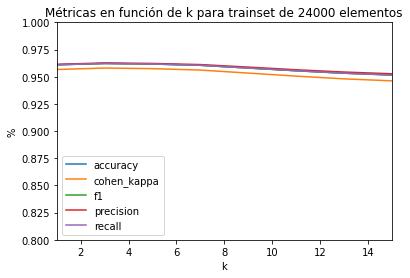

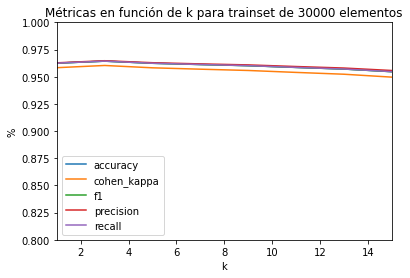

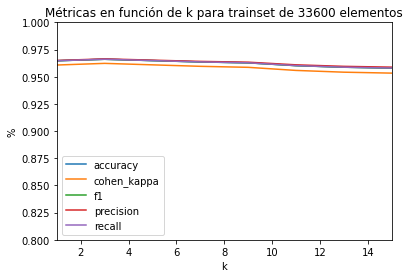

In [157]:
metrics = grouped.columns.values

def plot_metrics(train_size):
    xs = grouped.index.levels[1].values
    
    plt.title(f"Métricas en función de k para trainset de {train_size} elementos")
    plt.xlabel("k")
    plt.ylabel("%")

    for metric in metrics:
        ys = []
        for x in xs:
            ys.append(grouped.loc[train_size, x][metric])
        plt.plot(xs, ys)

    plt.axis([1, xs[-1], 0.8, 1])
    plt.gca().legend(tuple(metrics))
    plt.show()


for x in grouped.index.levels[0]:
    plot_metrics(x)

A simple vista notamos que el comportamiento de las métricas es compartido. Escojamos algunas e incrementemos la escala:

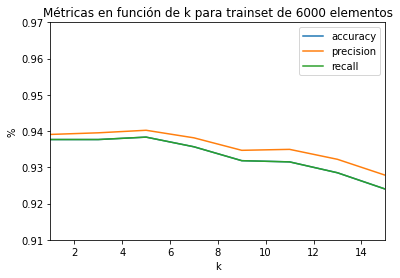

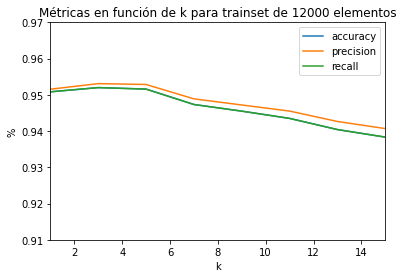

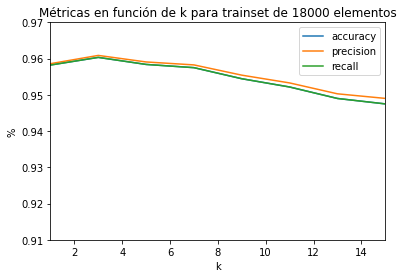

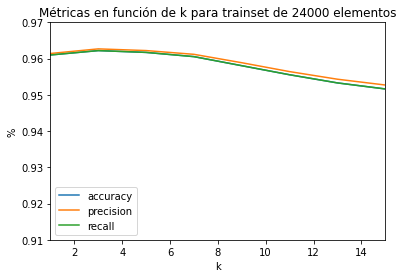

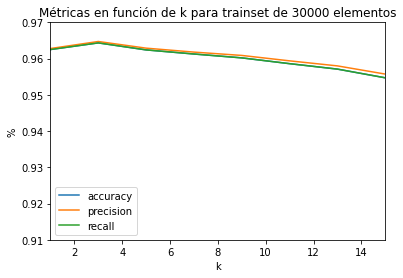

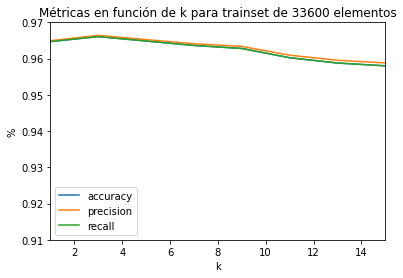

In [158]:
def plot_few_metrics(train_size):
    few_metrics = ['accuracy', 'precision', 'recall']
    
    xs = grouped.index.levels[1].values
    
    plt.title(f"Métricas en función de k para trainset de {train_size} elementos")
    plt.xlabel("k")
    plt.ylabel("%")

    for metric in few_metrics:
        ys = []
        for x in xs:
            ys.append(grouped.loc[train_size, x][metric])
        plt.plot(xs, ys)

    plt.axis([1, xs[-1], 0.91, 0.97])
    plt.gca().legend(tuple(few_metrics))
    plt.show()

    
for x in grouped.index.levels[0].values:
    plot_few_metrics(x)
    

Podemos observar dos cosas:
* Independientemente del tamaño del trainset, el intervalo óptimo se mantiene en [1;7]
* Conforme crece el tamaño del trainset, el valor de k que maximiza las métricas se va corriendo del 5 al 3. Particularmente, cuando el tamaño es 6000, el valor óptimo es 5; cuando éste es 12000, notamos una suerte de empate entre 3 y 5; y a partir de 18000, las métricas muestran mejores resultados con k igual a 3.

Esto deja la siguiente intriga: ¿qué ocurre cuando k vale 4? Recordemos que experimentamos únicamente con los valores impares del intervalo [1;15]. Quizás, deberíamos reiterar el experimento con el intervalo [1;7] y aumentar la granularidad.

Bueno, en realidad.....

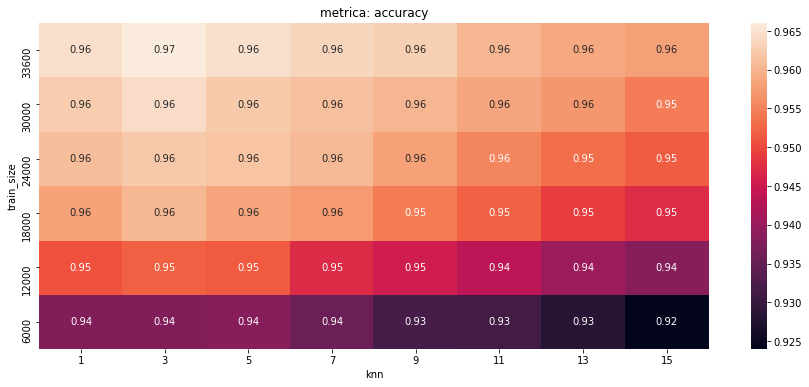

In [154]:
def pltHeatmap(metric):
    df = grouped.unstack(level=0)[metric].transpose()
    fig, ax = plt.subplots(figsize=(15,6))
    sns.heatmap(df, annot = True, ax=ax).invert_yaxis()
    plt.title(f"metrica: {metric}")
    plt.show()

# train_sizes = pd.unique(data['train_size'])
# [ 8400 16800 25200 33600]

# metrics = grouped.columns.values
# ['accuracy' 'cohen_kappa' 'f1' 'precision' 'recall']


#df = grouped.unstack(level=0)[metric]
#df = grouped.loc[:].unstack(level=0)[metric]

#df

pltHeatmap("accuracy")

Este mapa de calor nos muestra que a pesar de que no haya un valor del parámetro k que siempre maximice las métricas, la diferencia entre los resultados obtenidos cuando éste vale tres o cinco no es del todo apreciable. Más aún, en la mayoría de los casos se obtuvieron mejores resultados cuando se contmeplaron únicamente los tres vecinos más cercanos. Esto refuerza un poco la elección de utilizar k igual a 3 como parámetro más óptimo.

Mirando las otras métricas...

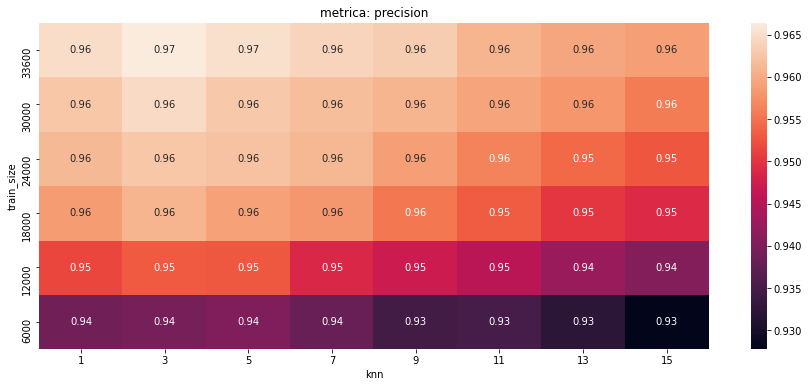

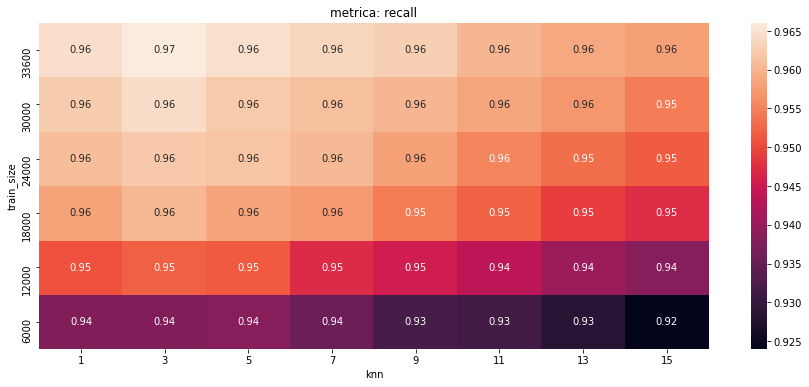

In [159]:
pltHeatmap("precision")
pltHeatmap("recall")

A grandes rasgos podemos concluir que:
* el intervalo óptimo para k se preserva a medida que se modifica el tamaño del trainset
* la elección de tomar k=3 parece ser la más adecuada: en la mayoria de los casos maximiza las métricas y en aquellos casos donde no, la diferencia es despreciable (bueno.... depende de la aplicación ?).
* existe una -leve- necesidad de experimentar con un intervalo más pequeño ([1;7]) aumentando la granularidad.

# Caso KNN+PCA

Para replicar el experimento únicamente sobre esta técnica:

> ./parallelknn_pca

Los resultados se almacenan en los directorios `knn_pca_results/`.


## Recuperar resultados

Primero, levantamos los resultados del experimento

In [5]:
knn_pca_data_files= os.listdir('knn_pca_results')

def load_files(filenames):
    for filename in filenames:
        yield pd.read_csv(f"knn_pca_results/{filename}")

knn_pca_data = pd.concat(load_files(knn_pca_data_files), ignore_index=True)

knn_pca_data.describe()

,accuracy,alpha,cohen_kappa,f1,kfold,knn,precision,recall,train_size
count,3240.000000,3240.000000,3240.000000,3240.000000,3240.0,3240.000000,3240.000000,3240.000000,3240.000000
mean,0.960942,65.000000,0.956555,0.960929,10.0,6.000000,0.961514,0.960942,20600.000000
std,0.010153,25.823874,0.011310,0.010158,0.0,3.416177,0.009718,0.010153,9686.534961
min,0.920000,25.000000,0.911014,0.919026,10.0,1.000000,0.920601,0.920000,6000.000000
25%,0.956667,45.000000,0.951780,0.956633,10.0,3.000000,0.957383,0.956667,12000.000000
50%,0.963889,65.000000,0.959841,0.963850,10.0,6.000000,0.964213,0.963889,21000.000000
75%,0.967778,85.000000,0.964164,0.967721,10.0,9.000000,0.968058,0.967778,30000.000000
max,0.978869,105.000000,0.976512,0.978881,10.0,11.000000,0.978957,0.978869,33600.000000


Luego, los agrupamos por tamaño del set de entrenamiento, parámetro de knn y de pca.

In [6]:
# podemos usar .mean() para resolver las métricas obtenidas de los distintos kfold

knn_pca_grpd = knn_pca_data.groupby(['train_size', 'knn', 'alpha']).mean()
knn_pca_grpd = knn_pca_grpd.drop(['kfold', 'predict_time'], axis=1)

knn_pca_grpd.head(20)

KeyError: "['predict_time'] not found in axis"

## Análisis

Para cada tamaño de trainset, calculamos los mejores 10 pares k-alpha que maximicen el accuracy.

In [32]:
def top_n_metric(n, metric):
    for size in knn_pca_grpd.index.levels[0].values:
        a = knn_pca_grpd.loc[size].accuracy.nlargest(20)
        print(f"Mejores {n} parejas con mayor {metric} para trainset de tamaño {size}")
        print(a)
        parejas=a.index.to_numpy()
        print("------------------")
        print("Intervalos optimos:")
        print(f"k: [{min(parejas, key = lambda t: t[0])[0]} ; {max(parejas, key = lambda t: t[0])[0]}]")
        print(f"alpha: [{min(parejas, key = lambda t: t[1])[1]} ; {max(parejas, key = lambda t: t[1])[1]}]")
        print("------------------")
        print("Pareja optima")
        print(parejas[0])
        print("==================")

top_n_metric(10, "accuracy")

Mejores 10 parejas con mayor accuracy para trainset de tamaño 6000
knn  alpha
5    45       0.949333
3    35       0.949333
     45       0.948333
7    45       0.948333
     35       0.948333
5    65       0.948167
     35       0.947833
     55       0.947833
     25       0.947667
7    55       0.947167
     25       0.947167
9    35       0.946833
5    75       0.946333
11   35       0.946167
5    85       0.945833
3    55       0.945500
7    65       0.945500
3    25       0.945333
1    95       0.945167
9    55       0.945000
Name: accuracy, dtype: float64
------------------
Intervalos optimos:
k: [1 ; 11]
alpha: [25 ; 95]
------------------
Pareja optima
(5, 45)
Mejores 10 parejas con mayor accuracy para trainset de tamaño 12000
knn  alpha
5    35       0.962250
3    45       0.961667
     35       0.960667
5    45       0.960083
1    35       0.959833
3    55       0.959833
7    35       0.959417
3    65       0.959250
1    45       0.959083
3    75       0.958833
1    55      

En primer lugar, observamos que los intervalos óptimos no se corrieron al variar el tamaño del trainset. Además, podemos ver que la pareja óptima converge a (3,35) conforme crece el tamaño. Concretamente, a partir de 18000, ya converge. Por lo tanto, podemos suponer que nuestra elección de pareja óptima también aplica para otros tamaños de trainset; no necesariamente maximizará el accuracy en todos los casos, pero si se mantendrá bastante cerca de la pareja en "primer lugar".

No obstante, estos resultados pueden llegar a presentar un problema... según recuerdo, la pareja óptima que obtuvo Gian era (6,35). Se me ocurren algunas posibilidades:
* o bien, le pifié a algo en el script que aplica knn+pca, particularmente en el manejo de los autovectores bajados a disco;
* o puede ser que el valor k=3 no formaba parte del intervalo que Gian contempló en su experimento. Para poder observar si el intervalo óptimo se movía de lugar, tuve que ampliar un poco el intervalo sobre el que experimenté. Quizás puede ser que ser que el 3 haya sido uno de los tantos valores que se agregaron al ampliar. 
* también, se puede atribuir a que este experimento toma únicamente los valores impares del intervalo propuesto para k; mientras que el experimento de Gian hace lo mismo pero para los pares.